In [16]:
import os
from pathlib import Path

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [20]:
AUDIO_FILE = Path("audio1.wav")
SAMPLING_RATE = 16000
DOG_BARK_CLASS = 3
CHUNK_SIZE = 16000
OVERLAP_PERCENT = 75
STRIDE = int((1 - OVERLAP_PERCENT / 100) * CHUNK_SIZE)
TEST_DIR = Path("test")


#DATA_DIR = Path("/content/drive/MyDrive/data")
DATA_DIR = Path("data")

MODEL_ID = f"Sr{SAMPLING_RATE}Cs{CHUNK_SIZE}Ol{OVERLAP_PERCENT}"
MODEL_FILE = DATA_DIR / "saved_models" / f"model.{MODEL_ID}"
MODEL_FILE_2D = DATA_DIR / "2d_saved_models" / f"model.{MODEL_ID}"
VGG_MODEL_FILE = DATA_DIR / "vgg_saved_models" / f"model.{MODEL_ID}"


In [21]:
CLASS_TO_NAME = {
    0: "air_conditioner",
    1: "car_horn",
    2: "children_playing",
    3: "dog_bark",
    4: "drilling",
    5: "engine_idling",
    6: "gun_shot",
    7: "jackhammer",
    8: "siren",
    9: "street_music",
}


In [22]:
def to_chunks(X, y, chunk_size, stride):
    """Split a numpy array into chunks of given size jumping stride indices each time"""
    chunks = []
    for start in range(0, len(X), stride):
        chunk = X[start : start + chunk_size]
        if len(chunk) == chunk_size:
            chunks.append(chunk)
        else:
            break
    y = np.repeat(y, len(chunks))
    return np.array(chunks), y, len(chunks)


In [23]:
IPython.display.Audio(str(AUDIO_FILE))


In [24]:
# read in audio
audio = librosa.load(AUDIO_FILE, sr=SAMPLING_RATE)[0]
audio, audio.shape


(array([-0.00880422, -0.01830477, -0.019983  , ...,  0.04043248,
         0.02406617, -0.00209045], dtype=float32),
 (64000,))

In [25]:
# break into overlapping chunks
Xs, ys, cnt = to_chunks(audio, DOG_BARK_CLASS, CHUNK_SIZE, STRIDE)
Xs, ys, cnt


(array([[-0.00880422, -0.01830477, -0.019983  , ...,  0.07019197,
          0.08964276,  0.10341053],
        [ 0.00650661,  0.01621788,  0.01501947, ...,  0.08607492,
          0.08655962,  0.07998115],
        [ 0.01231433, -0.00632314, -0.02276029, ..., -0.01082077,
         -0.01910723, -0.03118584],
        ...,
        [-0.06674592, -0.07606716, -0.07339358, ...,  0.04970319,
          0.03702813,  0.0206395 ],
        [ 0.04883597,  0.05254208,  0.04034698, ...,  0.05926504,
          0.04081336,  0.01096072],
        [ 0.0116318 ,  0.01081604,  0.01135967, ...,  0.04043248,
          0.02406617, -0.00209045]], dtype=float32),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 13)

In [26]:
def to_melspec(X, imgpath, height=72, width=72):
    dpi = plt.rcParams["figure.dpi"]
    figsize = (height / dpi, width / dpi)
    mel = librosa.feature.melspectrogram(y=X.reshape(CHUNK_SIZE))
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")
    librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), ax=ax)

    # https://stackoverflow.com/a/65469535
    fig.subplots_adjust(top=1.0, bottom=0, right=1.0, left=0, hspace=0, wspace=0)
    fig.savefig(imgpath)
    plt.show()
    plt.close(fig)


In [27]:
!rm -rf test/

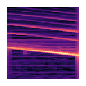

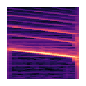

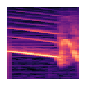

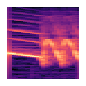

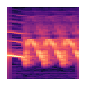

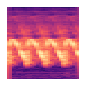

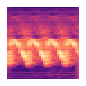

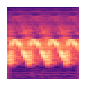

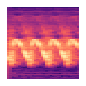

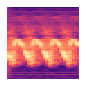

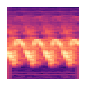

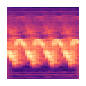

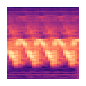

In [28]:
# convert to melspectogram
(TEST_DIR / f"{DOG_BARK_CLASS}").mkdir(parents=True, exist_ok=True)
for idx, X in enumerate(Xs):
    to_melspec(X, TEST_DIR / f"{DOG_BARK_CLASS}" / f"{idx:02}.jpg")


In [29]:
datagen = ImageDataGenerator(rescale=1.0 / 255)
generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=(72, 72),
    batch_size=100,
    shuffle=False,
)


Found 13 images belonging to 1 classes.


In [30]:
def sum_rule_agg(y, chunk_lens):
    return np.array(
        [res.mean(axis=0).argmax() for res in np.split(y, chunk_lens.cumsum()[:-1])]
    )


In [31]:
# for val_idx in range(10):
#     X = np.array(Xs)[..., np.newaxis]

#     datagen = ImageDataGenerator(rescale=1.0 / 255)
#     generator = datagen.flow_from_directory(
#         TEST_DIR,
#         target_size=(72, 72),
#         batch_size=100,
#         shuffle=False,
#     )

#     # load the model with the best weights
#     model1 = load_model(f"{MODEL_FILE}Vi{val_idx}")
#     model2 = load_model(f"{MODEL_FILE_2D}Vi{val_idx}")

#     y_pred1 = model1.predict(X)
#     y_pred2 = model2.predict(generator)

#     y_pred = 0.4 * y_pred1 + 0.6 * y_pred2
#     yavg = y_pred.sum(axis=0) / 13
#     y_pred_agg = sum_rule_agg(y_pred, np.array([13]))
#     print(f"probs = {yavg}, predicted class = {y_pred_agg[0]} ({CLASS_TO_NAME[y_pred_agg[0]]})")


In [32]:
val_idx = 4
X = np.array(Xs)[..., np.newaxis]

datagen = ImageDataGenerator(rescale=1.0 / 255)
generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=(72, 72),
    batch_size=100,
    shuffle=False,
)

# load the model with the best weights
model1 = load_model(f"{MODEL_FILE}Vi{val_idx}")
model2 = load_model(f"{MODEL_FILE_2D}Vi{val_idx}")

y_pred1 = model1.predict(X)
y_pred2 = model2.predict(generator)

y_pred = 0.4 * y_pred1 + 0.6 * y_pred2
yavg = y_pred.sum(axis=0) / cnt
y_pred_agg = sum_rule_agg(y_pred, np.array([cnt]))
y_pred_agg1 = sum_rule_agg(y_pred1, np.array([cnt]))
y_pred_agg2 = sum_rule_agg(y_pred2, np.array([cnt]))
yavg1 = y_pred1.sum(axis=0) / cnt
yavg2 = y_pred2.sum(axis=0) / cnt
print(
    f"1D probs = {yavg1}, predicted class = {y_pred_agg1[0]} ({CLASS_TO_NAME[y_pred_agg1[0]]})"
)
print(
    f"2D probs = {yavg2}, predicted class = {y_pred_agg2[0]} ({CLASS_TO_NAME[y_pred_agg2[0]]})"
)
print(
    f"Ensemble probs = {yavg}, predicted class = {y_pred_agg[0]} ({CLASS_TO_NAME[y_pred_agg[0]]})"
)


Found 13 images belonging to 1 classes.
1D probs = [8.6482883e-05 5.4364984e-05 3.6163290e-03 1.9663649e-03 4.3946219e-04
 1.7861363e-04 2.5356721e-04 6.1503968e-05 9.9290860e-01 4.3477817e-04], predicted class = 8 (siren)
2D probs = [3.8087171e-17 2.8596572e-13 1.5506591e-06 6.2695034e-02 1.7912658e-09
 4.0379125e-10 2.8157679e-13 1.6790559e-09 9.3712467e-01 1.7870932e-04], predicted class = 8 (siren)
Ensemble probs = [3.45931658e-05 2.17459947e-05 1.44746178e-03 3.84035669e-02
 1.75785972e-04 7.14456910e-05 1.01426886e-04 2.46025957e-05
 9.59438264e-01 2.81136890e-04], predicted class = 8 (siren)


In [33]:
# 1d+VGG 2D

val_idx = 4
X = np.array(Xs)[..., np.newaxis]

datagen = ImageDataGenerator(rescale=1.0 / 255)
generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=(72, 72),
    batch_size=100,
    shuffle=False,
)

# load the model with the best weights
model1 = load_model(f"{MODEL_FILE}Vi{val_idx}")
model2 = load_model(f"{VGG_MODEL_FILE}Vi{val_idx}")

y_pred1 = model1.predict(X)
y_pred2 = model2.predict(generator)

y_pred = 0.4 * y_pred1 + 0.6 * y_pred2
yavg = y_pred.sum(axis=0) / cnt
y_pred_agg = sum_rule_agg(y_pred, np.array([cnt]))
y_pred_agg1 = sum_rule_agg(y_pred1, np.array([cnt]))
y_pred_agg2 = sum_rule_agg(y_pred2, np.array([cnt]))
yavg1 = y_pred1.sum(axis=0) / cnt
yavg2 = y_pred2.sum(axis=0) / cnt
print(
    f"1D probs = {yavg1}, predicted class = {y_pred_agg1[0]} ({CLASS_TO_NAME[y_pred_agg1[0]]})"
)
print(
    f"2D probs = {yavg2}, predicted class = {y_pred_agg2[0]} ({CLASS_TO_NAME[y_pred_agg2[0]]})"
)
print(
    f"Ensemble probs = {yavg}, predicted class = {y_pred_agg[0]} ({CLASS_TO_NAME[y_pred_agg[0]]})"
)


Found 13 images belonging to 1 classes.
1D probs = [8.6482883e-05 5.4364984e-05 3.6163290e-03 1.9663649e-03 4.3946219e-04
 1.7861363e-04 2.5356721e-04 6.1503968e-05 9.9290860e-01 4.3477817e-04], predicted class = 8 (siren)
2D probs = [3.9316305e-06 7.6350225e-06 2.2638997e-02 1.2952290e-02 2.4608548e-03
 1.2371839e-04 1.2087747e-03 4.3543354e-05 9.6022075e-01 3.3939598e-04], predicted class = 8 (siren)
Ensemble probs = [3.6952140e-05 2.6327005e-05 1.5029931e-02 8.5579176e-03 1.6522980e-03
 1.4567650e-04 8.2669180e-04 5.0727609e-05 9.7329593e-01 3.7754889e-04], predicted class = 8 (siren)
